In [2]:
# working environment
!nvidia-smi

Wed Apr 12 07:38:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   45C    P8               37W / 390W|    229MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color='red'>Import the necessary libraries</font>

In [315]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

## <font color='red'>Fashion-MNIST is a popular benchmark dataset used in machine learning and computer vision tasks. It consists of a set of grayscale images of 10 different categories of fashion items, such as t-shirts, trousers, dresses, coats, sandals, sneakers, bags, ankle boots, etc. Each image in the dataset is a 28x28 pixel image, and there are 60,000 images in the training set and 10,000 images in the test set.</font>
 
    Fashion-MNIST is often used as a replacement for the original MNIST dataset, which consists of handwritten digits, as it provides a more challenging and realistic task for image classification algorithms. It was introduced as a drop-in replacement for MNIST to address some of its limitations, such as being too easy for modern machine learning algorithms and lacking diversity in image content.

    The Fashion-MNIST dataset is widely used for tasks such as image classification, object recognition, and fashion item recommendation. It is commonly used as a benchmark dataset for evaluating the performance of various machine learning models, including deep learning models, convolutional neural networks (CNNs), and other image recognition algorithms. It has become a standard dataset for researchers and practitioners in the field of computer vision and machine learning to evaluate and compare the performance of different models on a common task.

## <font color='red'>To begin, let's import the dataset from the TensorFlow library.</font>

In [286]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [287]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## <font color='red'>I will display some example images from the Fashion-MNIST dataset.</font>

In [288]:
def display_mnist_images(images, labels, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3))
    axes = axes.ravel()

    for i in np.arange(0, rows * cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(labels[i])

    plt.subplots_adjust(hspace=0.5)
    plt.show()

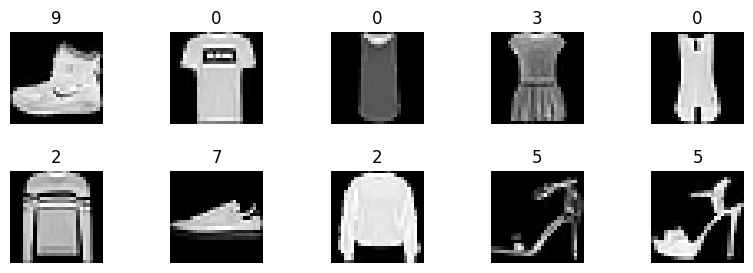

In [289]:
display_mnist_images(train_images[:10], train_labels[:10], rows=2, cols=5)

## <font color='red'>Before training, we need to preprocess the Fashion-MNIST dataset and convert it into a tensor dataset. Let's perform these preprocessing steps.</font>

In [290]:
def preprocess(img, lbl):
    img = tf.reshape(img, img.shape + [1])
    img = tf.keras.layers.Rescaling(1./255.)(img) 
    feature_engineering = tf.one_hot(lbl, depth=len(set(train_labels))) 
    return (img, feature_engineering), lbl

In [291]:
train = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE).cache()
test = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

## <font color='red'>Now, let's define the architecture of our model.</font>

    Here, we will implement a parallel layer architecture with multiple branches of inputs, which will be concatenated later to see the results at the end.

In [297]:
inputs = tf.keras.layers.Input(shape=list(train_images[0].shape) + [1])
engineering = tf.keras.layers.Input(shape=(10))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x_1 = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x_2 = tf.keras.layers.MaxPooling2D((2, 2))(x)

en = tf.keras.layers.Dense(128, activation='relu')(engineering)

x = tf.keras.layers.Concatenate()([x_1, x_2])
x = tf.keras.layers.Dense(32, activation="relu")(x)
 
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Concatenate()([x, en])

x = tf.keras.layers.Dense(256, activation="relu")(x)

outputs = tf.keras.layers.Dense(len(set(train_labels)), activation="softmax")(x)

model = tf.keras.Model([inputs, engineering], outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

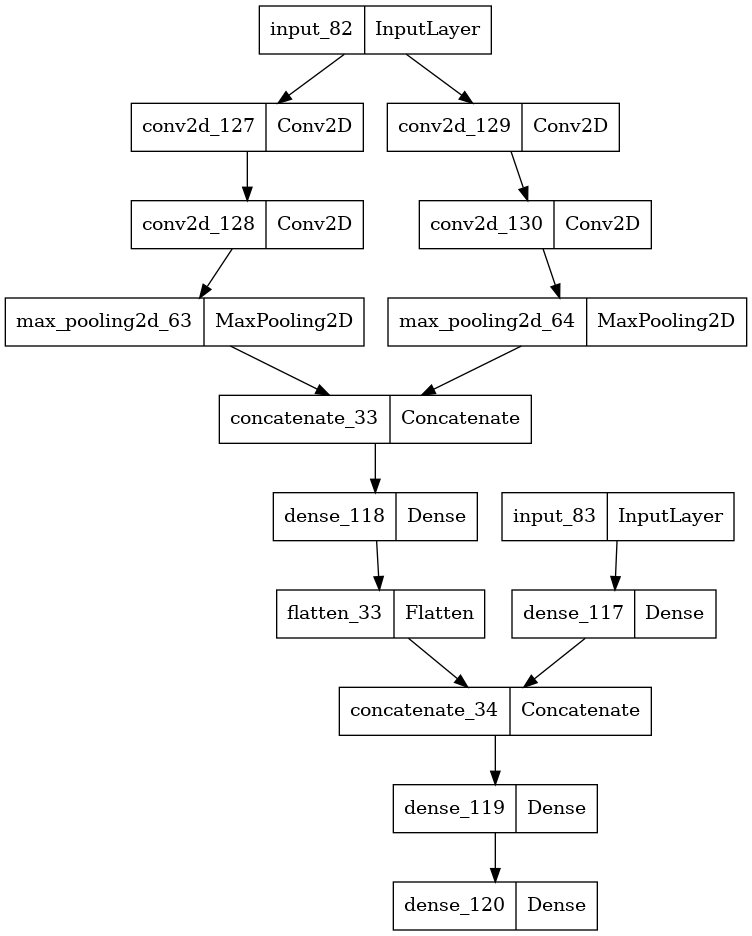

In [298]:
tf.keras.utils.plot_model(model)

## <font color='red'>Let's train our model without using any callback functions.</font>

In [299]:
model_history = model.fit(train, epochs=5, validation_data=test, validation_steps=len(test) * 0.2)

Epoch 1/5
1875/1875 [==============================] - 19s 9ms/step - loss: 0.0298 - accuracy: 0.9920 - val_loss: 6.0273e-05 - val_accuracy: 1.0000
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 2.6096e-05 - accuracy: 1.0000 - val_loss: 1.1240e-05 - val_accuracy: 1.0000
Epoch 3/5
1875/1875 [==============================] - 17s 9ms/step - loss: 5.7616e-06 - accuracy: 1.0000 - val_loss: 3.2259e-06 - val_accuracy: 1.0000
Epoch 4/5
1875/1875 [==============================] - 17s 9ms/step - loss: 1.7489e-06 - accuracy: 1.0000 - val_loss: 1.0451e-06 - val_accuracy: 1.0000
Epoch 5/5
1875/1875 [==============================] - 17s 9ms/step - loss: 5.7823e-07 - accuracy: 1.0000 - val_loss: 3.5106e-07 - val_accuracy: 1.0000


## <font color='red'>Let's save the trained model in the h5 format.</font>

In [304]:
model.save("saved-model.h5")

In [305]:
!ls saved-model.h5

saved-model.h5


## <font color='red'>Let's evaluate the performance of our model.</font>

<Axes: >

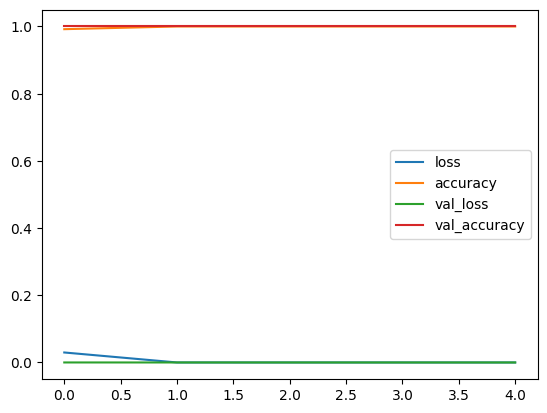

In [302]:
pd.DataFrame(model_history.history).plot()

In [317]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=12)
    plt.yticks(fontsize=12)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=12)

In [308]:
load_saved_model = tf.keras.models.load_model("saved-model.h5")

313/313 [==============================] - 1s 4ms/step


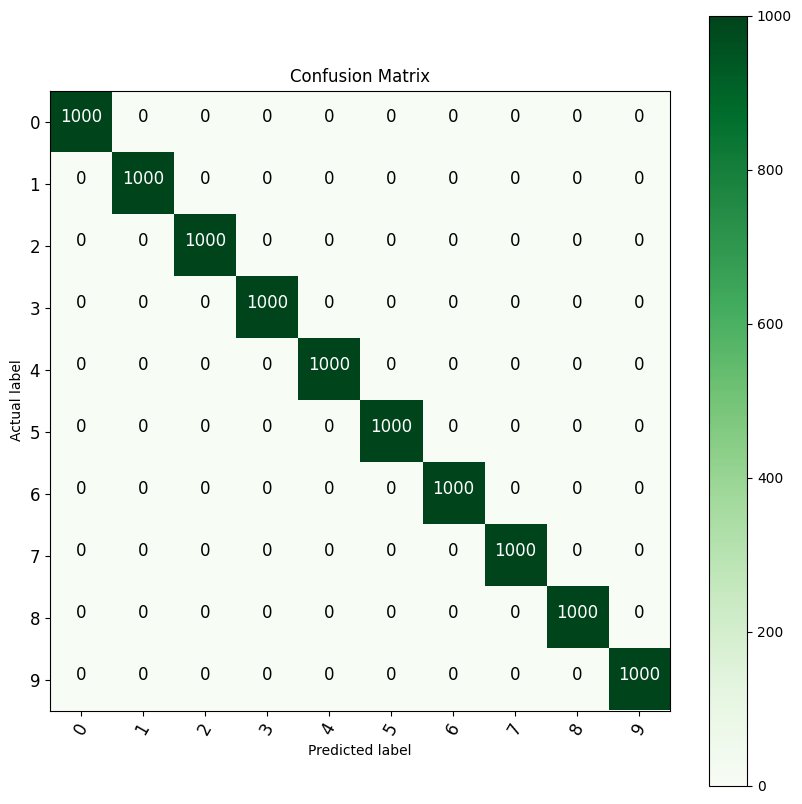

In [318]:
conf_matrix(y_test=test_labels, y_pred=load_saved_model.predict(test).argmax(axis=1), class_names=list(set(train_labels)))

# <font color='blue'>This result is remarkable because, if you search online, you will find that the maximum accuracy achieved in training the MNIST dataset is not 100%. I hope you can learn something from this trained model.</font>